In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../utils')
from features.prepare_for_training_adhd_zyy_v2 import prepare_for_training as prepare_train_adhd # type: ignore
from features.prepare_for_training_sex_zyy_v2 import prepare_for_training as prepare_train_sex # type: ignore
from features.prepare_for_trainning_wz import prepare_for_trainning as prepare_train_GCN # type: ignore
from opt_ensemble import Opt_Ensemble # type: ignore

In [2]:
main_dir = "F:/03--python/00__DataSet/widsdatathon2025/"
train_connectome = pd.read_csv(f"{main_dir}/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
test_connectome = pd.read_csv(f"{main_dir}/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
train_quantitative = pd.read_excel(f"{main_dir}/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
test_quantitative = pd.read_excel(f"{main_dir}/TEST/TEST_QUANTITATIVE_METADATA.xlsx")
train_solutions = pd.read_excel(f"{main_dir}/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")
sample_submission = pd.read_excel(f'{main_dir}/SAMPLE_SUBMISSION.xlsx')
train_cat = pd.read_excel(f"{main_dir}/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
test_cat = pd.read_excel(f"{main_dir}/TEST/TEST_CATEGORICAL.xlsx")
#print(train_quantitative.APQ_P_APQ_P_CP)

In [ ]:
from features.prepare_for_training_adhd_zyy_v2 import prepare_for_training as prepare_train_adhd # type: ignore
# prepare adhd data for training
target_name = 'ADHD_Outcome'
(X_train_adhd,y_train_adhd,X_test_adhd,y_test_adhd) = prepare_train_adhd(train_connectome, train_quantitative, train_cat,test_connectome,
                                                      test_quantitative, test_cat,train_solutions[target_name],sample_submission[target_name])
# adhd data for GCN
(X_train_adhd_GCN, X_test_adhd_GCN, train_metadata_features_adhd) = prepare_train_GCN(train_solutions, train_connectome, train_cat, 
                                                                                 sample_submission, test_connectome, test_cat, target_name)

metadata_dim_adhd = train_metadata_features_adhd.shape[1]  # 这应该是960，而不是30
print(f"使用的元数据维度: {metadata_dim_adhd}")

Selecting quantitative features for training data...
选中的定量特征索引: [ 24  26  28  32  35  39  45  49  60  62  92 101 104 106 130 132 138 171
 176 177]
Number of quantitative faetures for training data:  20
Selecting quantitative features for testing data...
Number ofquantitative faetures for testing data:  20
Selecting categorical features for training data...
选中的分类特征索引: [ 169  240  306  559  576  606  717  718  724  732  813  816  913  949
 1028 1072 1096 1107 1145 1176]
Number of categorical faetures for training data:  20
Selecting categorical features for testing data...
Number of categorical faetures for testing data:  20
Selecting connectome features for training data...
选中的功能连接数据特征索引: [ 4  6  7 11 12 13 15 18 19 25 26 31 35 36 37 39 41 43 44 46]
Number of connectome faetures for training data:  20
Selecting connectome features for testing data...
Number of connectome faetures for testing data:  20


from sklearn.model_selection import train_test_split
from features.treat_data_for_autoglun_wmy import treat_data_autoglun
label = 'ADHD_Outcome'
assert (X_train_adhd.index == y_train_adhd.index).all(), "索引不一致！"
X_train, X_temp, y_train, y_temp = train_test_split(X_train_adhd, y_train_adhd, test_size=0.2, random_state=42)
train_model3 = treat_data_autoglun(X_train,y_train,'ADHD_Outcome')
test_model3 = treat_data_autoglun(X_temp,y_temp,'ADHD_Outcome')
#y_temp.to_excel('y_temp.xlsx', index=True)  # index=False 不保存索引列
#test_model3.to_excel('test_model3.xlsx', index=True)  # index=False 不保存索引列

assert train_model3[label].notnull().all(), "标签列存在缺失值！"
assert not np.isinf(train_model3[label]).any(), "标签列存在无穷值！"

In [ ]:
label = 'ADHD_Outcome'
y_pred_adhd,ensemble_adhd = Opt_Ensemble(X_train_adhd,X_train_adhd_GCN, y_train_adhd,X_test_adhd,X_test_adhd_GCN,y_test_adhd,metadata_dim_adhd,label) 

No model was trained during hyperparameter tuning NeuralNetTorch_BAG_L1... Skipping this model.
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'XGBoost_BAG_L1\T4': 1.0}
	0.6268	 = Validation score   (f1_weighted)
	0.1s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 63.33s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 19760.5 rows/s (243 batch size)
Enabling decision threshold calibration (calibrate_decision_threshold='auto', metric is valid, problem_type is 'binary')
Calibrating decision threshold to optimize metric f1_weighted | Checking 51 thresholds...
Calibrating decision threshold via fine-grained search | Checking 38 thresholds...
	Base Threshold: 0.500	| val: 0.6268
	Best Threshold: 0.500	| val: 0.6268
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("f:\03--python\01__MyItems\WIDS\Ensemble_Model\AutogluonModels\ag-20250417_235633")


X 不是 Pandas DataFrame
y 是 Pandas 对象
基于计算阈值，model1 f1: 0.6929824561403509
基于计算阈值，model2 f1: 0.7063829787234043
基于计算阈值，model3 f1: 0.6962305986696231
基于计算阈值，ensemble f1: 0.6877828054298643


In [5]:
# 打印表头
print("{:<10} {:<10} {:<10}".format("Index", "y_true", "y_pred"))
print("-" * 30)

# 逐行打印数据
for i, (true, pred) in enumerate(zip(y_test_adhd, y_pred_adhd)):
    print("{:<10} {:<10} {:<10.2f}".format(i, true, pred))

Index      y_true     y_pred    
------------------------------
0          1          1.00      
1          0          1.00      
2          0          1.00      
3          1          1.00      
4          1          1.00      
5          1          1.00      
6          0          1.00      
7          0          1.00      
8          1          1.00      
9          1          1.00      
10         0          1.00      
11         1          1.00      
12         1          1.00      
13         1          0.00      
14         1          1.00      
15         0          1.00      
16         0          0.00      
17         1          1.00      
18         0          1.00      
19         0          1.00      
20         0          1.00      
21         1          1.00      
22         1          1.00      
23         1          1.00      
24         1          1.00      
25         0          1.00      
26         0          1.00      
27         0          1.00      
28         0

participant = np.linspace(1,y_test_adhd.size,y_test_adhd.size)
plt.figure(figsize=(10, 10), dpi=100)
plt.scatter(participant, y_test_adhd, color='blue')
plt.scatter(participant, y_pred_adhd, color='red')
plt.xlabel('Participant')
plt.ylabel('Predicted Sex')
plt.show()

In [ ]:
from features.prepare_for_training_sex_zyy_v2 import prepare_for_training as prepare_train_sex # type: ignore
# prepare adhd data for training
target_name = 'Sex_F'
(X_train_sex,y_train_sex,X_test_sex,y_test_sex) = prepare_train_sex(train_quantitative, train_connectome,test_quantitative, test_connectome,
                                                                    train_solutions[target_name],sample_submission[target_name])
# data for sex GCN
(X_train_sex_GCN, X_test_sex_GCN, train_metadata_features_sex) = prepare_train_GCN(train_solutions, train_connectome, train_cat, 
                                                                                 sample_submission, test_connectome, test_cat, target_name)

metadata_dim_sex = train_metadata_features_sex.shape[1]  # 这应该是960，而不是30
print(f"使用的元数据维度: {metadata_dim_sex}")

Selecting quantitative features for training data...
选中的定量特征索引: [ 13  26  29  67 101 124 128 132 133 135 136 138 140 141 144 145 146 147
 148 149 150 154 162 164 165 173 175 179 180 186]
Number of quantitative faetures for training data:  30
Selecting quantitative features for testing data...
Number ofquantitative faetures for testing data:  30
Selecting connectome features for training data...
选中的功能连接数据特征索引: [ 0  1  2  6  7  9 10 12 13 14 16 19 20 21 23 26 27 28 29 30 32 34 35 36
 37 39 40 44 45 47]
Number of connectome faetures for training data:  30
Selecting connectome features for testing data...
Number of connectome faetures for testing data:  30


In [ ]:
label = 'Sex_F'
y_pred_sex,ensemble_sex = Opt_Ensemble(X_train_sex,X_train_sex_GCN,y_train_sex,X_test_sex,X_test_sex_GCN,y_test_sex,metadata_dim_sex,label)

No model was trained during hyperparameter tuning NeuralNetTorch_BAG_L1... Skipping this model.
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'XGBoost_BAG_L1\T2': 1.0}
	0.6064	 = Validation score   (f1_weighted)
	0.1s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 48.39s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 21634.7 rows/s (243 batch size)
Enabling decision threshold calibration (calibrate_decision_threshold='auto', metric is valid, problem_type is 'binary')
Calibrating decision threshold to optimize metric f1_weighted | Checking 51 thresholds...
Calibrating decision threshold via fine-grained search | Checking 38 thresholds...
	Base Threshold: 0.500	| val: 0.6064
	Best Threshold: 0.500	| val: 0.6064
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("f:\03--python\01__MyItems\WIDS\Ensemble_Model\AutogluonModels\ag-20250418_001200")


X 不是 Pandas DataFrame
y 是 Pandas 对象
基于计算阈值，model1 f1: 0.5689655172413793
基于计算阈值，model2 f1: 0.6510538641686182
基于计算阈值，model3 f1: 0.4676258992805755
基于计算阈值，ensemble f1: 0.37554585152838427


In [8]:
# 打印表头
print("{:<10} {:<10} {:<10}".format("Index", "y_true", "y_pred"))
print("-" * 30)

# 逐行打印数据
for i, (true, pred) in enumerate(zip(y_test_sex, y_pred_sex)):
    print("{:<10} {:<10} {:<10.2f}".format(i, true, pred))

Index      y_true     y_pred    
------------------------------
0          0          1.00      
1          0          0.00      
2          1          0.00      
3          0          0.00      
4          0          0.00      
5          0          0.00      
6          1          0.00      
7          1          1.00      
8          1          0.00      
9          1          0.00      
10         0          0.00      
11         0          0.00      
12         0          1.00      
13         0          0.00      
14         1          0.00      
15         0          0.00      
16         0          1.00      
17         1          0.00      
18         1          0.00      
19         1          0.00      
20         0          0.00      
21         0          0.00      
22         0          0.00      
23         1          0.00      
24         0          0.00      
25         1          1.00      
26         1          0.00      
27         0          0.00      
28         1

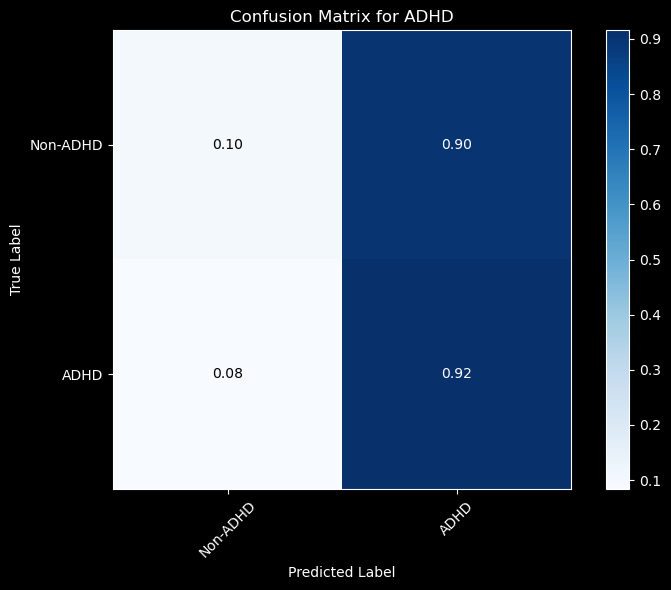

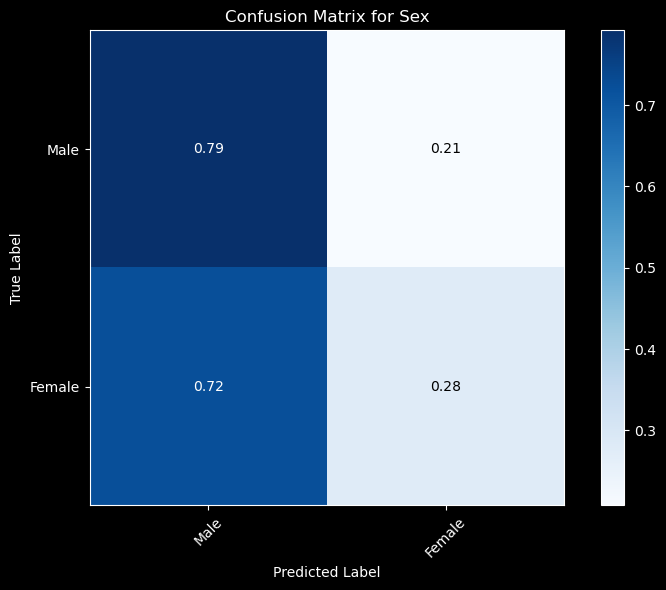

In [9]:
from plotting.plot_confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(y_test_adhd, y_pred_adhd, classes = ['Non-ADHD', 'ADHD'], normalize=True, title='Confusion Matrix for ADHD')
plot_confusion_matrix(y_test_sex, y_pred_sex, classes = ['Male', 'Female'], normalize=True, title='Confusion Matrix for Sex')

In [10]:
from sklearn.metrics import classification_report
import numpy as np
y_train_pred_adhd = ensemble_adhd.predict(X_train_adhd, y_train_adhd)
print(classification_report(y_train_adhd,ensemble_adhd.predict(X_train_adhd,y_train_adhd)))
np.sum(y_pred_adhd)
print(y_train_pred_adhd)

X 不是 Pandas DataFrame
y 是 Pandas 对象
基于计算阈值，model1 f1: 0.8873465029364656
基于计算阈值，model2 f1: 0.8143067123958844
基于计算阈值，model3 f1: 1.0
基于计算阈值，ensemble f1: 1.0
X 不是 Pandas DataFrame
y 是 Pandas 对象
基于计算阈值，model1 f1: 0.8873465029364656
基于计算阈值，model2 f1: 0.8143067123958844
基于计算阈值，model3 f1: 1.0
基于计算阈值，ensemble f1: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       382
           1       1.00      1.00      1.00       831

    accuracy                           1.00      1213
   macro avg       1.00      1.00      1.00      1213
weighted avg       1.00      1.00      1.00      1213

[1 1 1 ... 0 0 0]


In [11]:
from sklearn.metrics import classification_report
import numpy as np
y_train_pred_sex = ensemble_sex.predict(X_train_sex, y_train_sex)
print(classification_report(y_train_sex,ensemble_sex.predict(X_train_sex,y_train_sex)))
np.sum(y_pred_sex)
print(y_train_pred_sex)

X 不是 Pandas DataFrame
y 是 Pandas 对象
基于计算阈值，model1 f1: 0.7725856697819314
基于计算阈值，model2 f1: 0.8867102396514162
基于计算阈值，model3 f1: 0.9987995198079231
基于计算阈值，ensemble f1: 1.0
X 不是 Pandas DataFrame
y 是 Pandas 对象
基于计算阈值，model1 f1: 0.7725856697819314
基于计算阈值，model2 f1: 0.8867102396514162
基于计算阈值，model3 f1: 0.9987995198079231
基于计算阈值，ensemble f1: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       797
           1       1.00      1.00      1.00       416

    accuracy                           1.00      1213
   macro avg       1.00      1.00      1.00      1213
weighted avg       1.00      1.00      1.00      1213

[1 0 0 ... 1 0 0]


plt.figure(figsize=(10, 10), dpi=100)
plt.scatter(participant, y_test_sex, color='blue')
plt.scatter(participant, y_pred_sex, color='red')
plt.xlabel('Participant')
plt.ylabel('Predicted Sex')
plt.show()